# Import


In [ ]:
import pandas as pd
import numpy as np

import json
import re

from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer

import matplotlib.pyplot as plt

import pickle

from tqdm.auto import tqdm
tqdm.pandas(desc='Tokenizing rows')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
model_name = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
category_tree = pd.read_csv('category_tree.csv')

In [ ]:
labeled_train = pd.read_parquet('labeled_train.parquet')

In [ ]:
unlabeled_train = pd.read_parquet('unlabeled_train.parquet')

# EDA

## category_tree

In [ ]:
category_tree.head()

,cat_id,parent_id,cat_name
0,1,NaN,Электроника
1,2,NaN,Ноутбуки и компьютеры
2,3,NaN,Бытовая техника
3,4,NaN,Детские товары
4,5,NaN,"Дача, сад и огород"


In [ ]:
category_tree.tail()

,cat_id,parent_id,cat_name
1891,31426,14355.0,Аккумуляторы для мобильных телефонов
1892,31431,14355.0,Коннекторы и контейнеры для телефонов
1893,31433,14355.0,Корпусные детали для телефонов
1894,31434,14355.0,Клавиатуры и кнопки для телефонов
1895,31435,14355.0,Прочие запчасти для мобильных устройств


In [ ]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1896 entries, 0 to 1895
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cat_id     1896 non-null   int64  
 1   parent_id  1873 non-null   float64
 2   cat_name   1896 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 44.6+ KB


In [ ]:
category_tree.nunique()

,0
cat_id,1896
parent_id,490
cat_name,1709


In [ ]:
# проверяем дубликаты
duplicates = category_tree[category_tree['cat_name'].duplicated()]
duplicates.sort_values('cat_name')

,cat_id,parent_id,cat_name
339,1280,123.0,4K гейминг
920,3538,459.0,DJ-оборудование
337,1276,123.0,Nintendo
1717,14324,1099.0,PlayStation
945,3636,436.0,PlayStation
...,...,...,...
750,2593,271.0,"Шторы, карнизы, декор окна"
1465,12579,2428.0,Экраны для ванн
549,2015,202.0,Электробритвы мужские
307,1185,113.0,Электроника


In [ ]:
# удаляем дубликаты
category_tree.drop_duplicates(subset='cat_name', inplace=True)

In [ ]:
# заменяем NaN в parent_id на 0.0
category_tree['parent_id'] = category_tree['parent_id'].fillna(0)

In [ ]:
# преобразовываем типы данных
category_tree['parent_id'] = category_tree['parent_id'].astype(int)
category_tree['cat_name'] = category_tree['cat_name'].astype('category')
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1709 entries, 0 to 1894
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   cat_id     1709 non-null   int64   
 1   parent_id  1709 non-null   int64   
 2   cat_name   1709 non-null   category
dtypes: category(1), int64(2)
memory usage: 121.3 KB


In [ ]:
def find_max_length(df: pd.Dataframe) -> list:
    """
    Находит максимальную длину последовательности.
    """
    tokenized_texts = df['cat_name']
    return [len(tokenizer.tokenize(text)) for text in tqdm(tokenized_texts)]


# определяем максимальную длину токенов
lst_length = find_max_length(category_tree)
max_length = max(lst_length)  # максимальная длина
mean_length = np.mean(lst_length)  # средняя длина
percentile_95 = np.percentile(lst_length, 95)  # 95-й перцентиль

print(max_length)
print(mean_length)
print(percentile_95)

  0%|          | 0/1896 [00:00<?, ?it/s]

18
5.290611814345992
10.0


In [ ]:
max_length_category_tree = 10

**Вывод:**
В начале идут базовые категории, без родительского класса, и постепенно опускаются вниз по дереву.  В cat_name присутствуют дубликаты, возможно стоит проработать, чтоб остался один cat_id для одного cat_name. В данном случае я сделал drop_duplicates. Также все NaN в parent_id были заменены значением 0.0, а значения преобразованы в int. В столбце cat_name данные были преобразованы в формат category. max_length_category_tree = 10 (95 перцентиль).

## labeled_train

In [ ]:
labeled_train.head()

,hash_id,source_name,attributes,cat_id
0,00002c14676b6a5c02d01fd82a92bd50,"Бойник барабана для стиральной машины Candy, V...","[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",10501
1,00002d434ee4516d75b9e99cb4b6b4fb,Приемное устройство М1 TDM Уютный дом в монтаж...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",140
2,000055da1f1a715b7a8c955e4002ade2,Духовой шкаф электрический Darina 1U5 BDE 112 ...,"[{""""attribute_id"""":6,""""attribute_name"""":""""Штри...",1397
3,000065493de83bdbacf9093b9e139cbb,Коврик для мыши 40*70 см Genshin Impact Desk M...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",3645
4,00006bee8d0f6056ac09833a2cee2b8c,"Ripo Кабель для интернет-соединения, серый","[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",10421


In [ ]:
labeled_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716552 entries, 0 to 716551
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   hash_id      716552 non-null  object
 1   source_name  716552 non-null  object
 2   attributes   716552 non-null  object
 3   cat_id       716552 non-null  int32 
dtypes: int32(1), object(3)
memory usage: 19.1+ MB


In [ ]:
labeled_train['cat_id'].nunique()

776

In [ ]:
labeled_train['source_name'].nunique()

631024

In [ ]:
# проверяем дубликаты
duplicates = labeled_train[labeled_train['source_name'].duplicated()]
duplicates.sort_values('source_name')

,hash_id,source_name,attributes,cat_id
255216,5b246c792b65b1692af4be95e45405c6,#cokebox Аксессуар для микрофона универсальный...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",10152
625157,df3d07c2918cff8ec0a002c837c10371,(0957-2385) Блок питания адаптер для принтера ...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",31405
385790,89ba9380bec110dfc4904bf91762abac,(1466932) Ролик захвата бумаги на оси в сборе ...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",31405
688648,f60e11f939ff87ef6a592c5d23249e8d,(1469197) Абсорбер В СБОРЕ (поглотитель чернил...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",31405
339108,78fd22ca56fa860e0440bd193d959911,(1550842) Шлейф печатающей головки Epson L800/...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",31405
...,...,...,...,...
557538,c70bc06ca418b330b109713f1222073b,электрический универсальный коврик с подогревом,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",2473
700386,fa45fc499ce89ceed534b8aefa76b0f8,электрический универсальный коврик с подогревом,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",2473
167208,3ba3169a316fd66dffd8e1190e87388c,электрический универсальный коврик с подогревом,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",2473
471310,a83844a446f1e977f25f081e9a612a7a,электрический универсальный коврик с подогревом,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",2473


In [ ]:
# удаляем дубликаты
labeled_train.drop_duplicates(subset='source_name', inplace=True)
labeled_train.drop('hash_id', axis=1, inplace=True)
labeled_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 631024 entries, 0 to 716550
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   source_name  631024 non-null  object
 1   attributes   631024 non-null  object
 2   cat_id       631024 non-null  int32 
dtypes: int32(1), object(2)
memory usage: 16.9+ MB


In [ ]:
# преобразуем атрибуты из json в текст
def attributes_to_text(attr_json) -> str:
    """
    Извлекает атрибуты из json в строку.
    """
    try:
        attributes = json.loads(attr_json.replace('""', '"'))

        attr_texts = [
            f"{attr['attribute_name']}: {attr['attribute_value']}"
            for attr in attributes if attr['attribute_name'] not in
            ['Название', 'В наличии', 'Ebsmstock']
        ]

        return '. '.join(attr_texts) if attr_texts else 'нет'

    except Exception as e:
        return 'Атрибуты отсутствуют'


# применяем ко всему датасету
labeled_train['attributes'] = labeled_train['attributes'].apply(
    attributes_to_text)
labeled_train.head()

In [ ]:
def cleaned_text(text) -> str:
    """
    Простая очистка текста.
    """
    text = str(
        text
    ) if text is not None else ''  # преобразуем text в строку, если это не строка
    text = text.lower()
    text = re.sub(r'[^а-яёa-z0-9\s.,*!?:-]', '',
                  text)  # удаление лишних символов (кроме пунктуации)
    text = re.sub(r'\s+', ' ', text).strip()  # удаление лишних пробелов
    return text


# применяем ко всему датасету
labeled_train['attributes'] = labeled_train['attributes'].apply(cleaned_text)
labeled_train['source_name'] = labeled_train['source_name'].apply(cleaned_text)
labeled_train.head()

In [ ]:
# извлекаем данные из атрибутов, создаем новые фичи
def extract_info(attr_str):
    """
    Извлекает структурированные данные из текстовой строки с атрибутами товара, 
    представленной в виде одного объединённого текста. Возвращает кортеж 
    с основными характеристиками товара.
    
    :param attr_str: cтрока с описанием атрибутов товара
    :return: кортеж из элементов.
    """
    # преобразуем attr_str в строку, если это не строка
    attr_str = str(attr_str) if attr_str is not None else ''

    # извлекаем поставщика
    supplier_match = re.search(r'поставщик:\s*([^\.]+)', attr_str)
    if supplier_match:
        supplier = supplier_match.group(1).strip()
        if supplier.lower() == "нет бренда":  # если поставщик - нет бренда
            supplier = None
    else:
        supplier = None

    # извлекаем модель устройства
    model_match = re.search(r'модель устройства:\s*([^\.]+)', attr_str)
    model = model_match.group(1).strip() if model_match else None

    # извлекаем страну
    country_match = re.search(r'страна:\s*([^\.]+)', attr_str)
    country = country_match.group(1).strip() if country_match else None

    # извлекаем материал
    material_match = re.search(r'материал:\s*([^\.]+)', attr_str)
    material = material_match.group(1).strip() if material_match else None

    # извлекаем самовывоз (1 = да, 0 = нет)
    pickup_match = re.search(r'возможность самовывоза:\s*(да|нет)', attr_str)
    pickup = 1 if pickup_match and pickup_match.group(1) == 'да' else 0

    # извлекаем доставку (1 = да, 0 = нет)
    delivery_match = re.search(r'возможность доставки:\s*(да|нет)', attr_str)
    delivery = 1 if delivery_match and delivery_match.group(1) == 'да' else 0

    # извлекаем гарантию (1 = да, 0 = нет)
    guarantee_match = re.search(r'гарантия:\s*(да|нет)', attr_str)
    guarantee = 1 if guarantee_match and guarantee_match.group(
        1) == 'да' else 0

    # извлекаем вес
    weight_match = re.search(r'вес:\s*([^\.]+)', attr_str)
    if weight_match:
        weight_str = weight_match.group(1).strip()
        # убираем запятую и пробелы, если они есть
        weight_str = weight_str.replace(',', '.').replace(' ', '')
        try:
            weight = float(weight_str)
        except ValueError:
            weight = None  # если преобразование не удалось, устанавливаем None
    else:
        weight = None

    # извлекаем габариты
    size_match = re.search(
        r'размер: длина\s*(\d+)\s*ширина\s*(\d+)\s*высота\s*(\d+)', attr_str)
    if size_match:
        length, width, height = map(int, size_match.groups())
    else:
        length, width, height = None, None, None  # если измерения не найдены

    # извлекаем габариты упаковки
    size_match_p = re.search(
        r'ширина упаковки:\s*(\d+)\.\s*высота упаковки:\s*(\d+)\.\s*глубина упаковки:\s*(\d+)',
        attr_str)
    if size_match_p:
        length_p, width_p, height_p = map(int, size_match_p.groups())
    else:
        length_p, width_p, height_p = None, None, None  # если измерения не найдены

    # удаляем обработанные атрибуты из строки
    cleaned_attrs = re.sub(r'поставщик:\s*[^\.]+\.?', '', attr_str)
    cleaned_attrs = re.sub(r'возможность самовывоза:\s*(да|нет)\.?', '',
                           cleaned_attrs)
    cleaned_attrs = re.sub(r'страна:\s*[^\.]+\.?', '', cleaned_attrs)
    cleaned_attrs = re.sub(r'материал:\s*[^\.]+\.?', '', cleaned_attrs)
    cleaned_attrs = re.sub(r'модель устройства:\s*[^\.]+\.?', '',
                           cleaned_attrs)
    cleaned_attrs = re.sub(r'возможность доставки:\s*(да|нет)\.?', '',
                           cleaned_attrs)
    cleaned_attrs = re.sub(r'гарантия:\s*(да|нет)\.?', '', cleaned_attrs)
    cleaned_attrs = re.sub(r'вес\s*\d+\.?', '', cleaned_attrs)
    cleaned_attrs = re.sub(
        r'размер: длина\s*\d+\s*ширина\s*\d+\s*высота\s*\d+\.?', '',
        cleaned_attrs)
    cleaned_attrs = re.sub(
        r'ширина упаковки\s*\d+\s*высота упаковки\s*\d+\s*глубина упаковки\s*\d+\.?',
        '', cleaned_attrs)

    return supplier, country, material, model, pickup, length, width, height, delivery, guarantee, weight, length_p, width_p, height_p

In [ ]:
# применяем к DataFrame
labeled_train[[
    'поставщик', 'страна', 'материал', 'модель', 'самовывоз', 'длина',
    'ширина', 'высота', 'возможность доставки', 'гарантия', 'вес', 'длина_уп',
    'ширина_уп', 'высота_уп'
]] = labeled_train['attributes'].progress_apply(
    lambda x: pd.Series(extract_info(x)))

# удаляем старый столбец
labeled_train.drop(columns=['attributes'], inplace=True)
labeled_train.reset_index(drop=True, inplace=True)
labeled_train.head()

Tokenizing rows:   0%|          | 0/631024 [00:00<?, ?it/s]

,source_name,cat_id,поставщик,страна,материал,модель,самовывоз,длина,ширина,высота,возможность доставки,гарантия,вес,длина_уп,ширина_уп,высота_уп
0,"бойник барабана для стиральной машины candy, v...",10501,None,турция,пластик,кх-0012297,1.0,18.0,5.0,5.0,0.0,0.0,100.0,NaN,NaN,NaN
1,приемное устройство м1 tdm уютный дом в монтаж...,140,tdm electric,китай,None,sq1508-0213,1.0,5.0,5.0,10.0,0.0,1.0,150.0,NaN,NaN,NaN
2,духовой шкаф электрический darina 1u5 bde 112 ...,1397,darina,None,None,электрический 1u5 bde 112 708 x5 серебристый 0...,1.0,NaN,NaN,NaN,1.0,0.0,35900.0,NaN,NaN,NaN
3,коврик для мыши 40*70 см genshin impact desk m...,3645,genshin impact,китай,None,desk matzephyr of the violet garden,1.0,70.0,40.0,1.0,0.0,0.0,600.0,NaN,NaN,NaN
4,"ripo кабель для интернет-соединения, серый",10421,ripo,None,None,003-300007,1.0,17.0,14.0,3.0,0.0,1.0,61.0,NaN,NaN,NaN


In [ ]:
labeled_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631024 entries, 0 to 631023
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   source_name           631024 non-null  object 
 1   cat_id                631024 non-null  int32  
 2   поставщик             468708 non-null  object 
 3   страна                242136 non-null  object 
 4   материал              47296 non-null   object 
 5   модель                271935 non-null  object 
 6   самовывоз             631024 non-null  float64
 7   длина                 197128 non-null  float64
 8   ширина                197128 non-null  float64
 9   высота                197128 non-null  float64
 10  возможность доставки  631024 non-null  float64
 11  гарантия              631024 non-null  float64
 12  вес                   272060 non-null  float64
 13  длина_уп              281 non-null     float64
 14  ширина_уп             281 non-null     float64
 15  

In [ ]:
# рассчитываем пропуски
for j in labeled_train.columns:
    a = round(labeled_train[j].isna().sum() / labeled_train.shape[0] * 100, 3)
    print(f'Доля пропусков в {j}: {a}%')

Доля пропусков в source_name: 0.0%
Доля пропусков в cat_id: 0.0%
Доля пропусков в поставщик: 25.723%
Доля пропусков в страна: 61.628%
Доля пропусков в материал: 92.505%
Доля пропусков в модель: 56.906%
Доля пропусков в самовывоз: 0.0%
Доля пропусков в длина: 68.761%
Доля пропусков в ширина: 68.761%
Доля пропусков в высота: 68.761%
Доля пропусков в возможность доставки: 0.0%
Доля пропусков в гарантия: 0.0%
Доля пропусков в вес: 56.886%
Доля пропусков в длина_уп: 99.955%
Доля пропусков в ширина_уп: 99.955%
Доля пропусков в высота_уп: 99.955%


In [ ]:
labeled_train.describe()

,cat_id,самовывоз,длина,ширина,высота,возможность доставки,гарантия,вес,длина_уп,ширина_уп,высота_уп
count,631024.000000,631024.000000,197128.000000,197128.000000,197128.000000,631024.000000,631024.000000,272060.000000,281.000000,281.000000,281.000000
mean,7316.848581,0.438757,22.059611,14.978598,10.333291,0.143346,0.279184,2001.692490,12.131673,7.540925,20.886121
std,8532.175257,0.496235,20.415856,13.232205,16.588374,0.350426,0.448599,8430.897288,10.271342,8.488181,16.467973
min,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000
25%,1054.000000,0.000000,10.000000,7.000000,3.000000,0.000000,0.000000,69.000000,5.000000,3.000000,12.000000
50%,2433.000000,0.000000,17.000000,10.000000,5.000000,0.000000,0.000000,200.000000,10.000000,5.000000,16.000000
75%,10501.000000,1.000000,28.000000,18.000000,10.000000,0.000000,1.000000,520.000000,12.000000,8.000000,25.000000
max,31435.000000,1.000000,800.000000,500.000000,1295.000000,1.000000,1.000000,176600.000000,74.000000,65.000000,152.000000


In [ ]:
labeled_train.describe(include='object')

,source_name,поставщик,страна,материал,модель
count,631024,468708,242136,47296,271935
unique,627648,14229,333,1239,207513
top,робот-пылесос xiaomi robot vacuum x10 eu,desktop 365,китай,пластик,2
freq,4,21126,169986,11536,215


In [ ]:
# объединяем source_name и модель в новый столбец source_name_model и удаляем их
labeled_train['name'] = labeled_train.apply(
    lambda row:
    f"{row['source_name']}{'' if pd.isna(row['модель']) else '.'} {'' if pd.isna(row['модель']) else row['модель']}"
    .strip(),
    axis=1)
labeled_train.drop(['source_name', 'модель'], axis=1, inplace=True)

In [ ]:
# удаляем столбцы где много пропусков
labeled_train.drop([
    'поставщик', 'страна', 'длина', 'ширина', 'высота', 'вес', 'материал',
    'длина_уп', 'ширина_уп', 'высота_уп'
],
                   axis=1,
                   inplace=True)

In [ ]:
# преобразовываем данные в более оптимальные типы
for i in labeled_train.columns:
    if labeled_train[i].dtype == 'object':
        labeled_train[i] = labeled_train[i].astype('category')
    if i in ('самовывоз', 'возможность доставки', 'гарантия'):
        labeled_train[i] = labeled_train[i].astype('int8')
labeled_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631024 entries, 0 to 631023
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   cat_id                631024 non-null  int32   
 1   самовывоз             631024 non-null  int8    
 2   возможность доставки  631024 non-null  int8    
 3   гарантия              631024 non-null  int8    
 4   source_name_model     631024 non-null  category
dtypes: category(1), int32(1), int8(3)
memory usage: 27.5 MB


In [ ]:
# кодируем cat_id с помощью LabelEncoder()
label_encoder = LabelEncoder()
labeled_train['label'] = label_encoder.fit_transform(labeled_train['cat_id'])
num_classes = len(label_encoder.classes_)
labeled_train.head()

,cat_id,самовывоз,возможность доставки,гарантия,source_name_model,label
0,10501,1,0,0,"бойник барабана для стиральной машины candy, v...",387
1,140,1,0,1,приемное устройство м1 tdm уютный дом в монтаж...,13
2,1397,1,1,0,духовой шкаф электрический darina 1u5 bde 112 ...,120
3,3645,1,0,0,коврик для мыши 40*70 см genshin impact desk m...,290
4,10421,1,0,1,"ripo кабель для интернет-соединения, серый. 00...",370


In [ ]:
# сохраняем encoder
with open('encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
# сохраняем датасет
labeled_train.to_parquet('df.parquet', index=False)

### Анализ дисбаланса классов

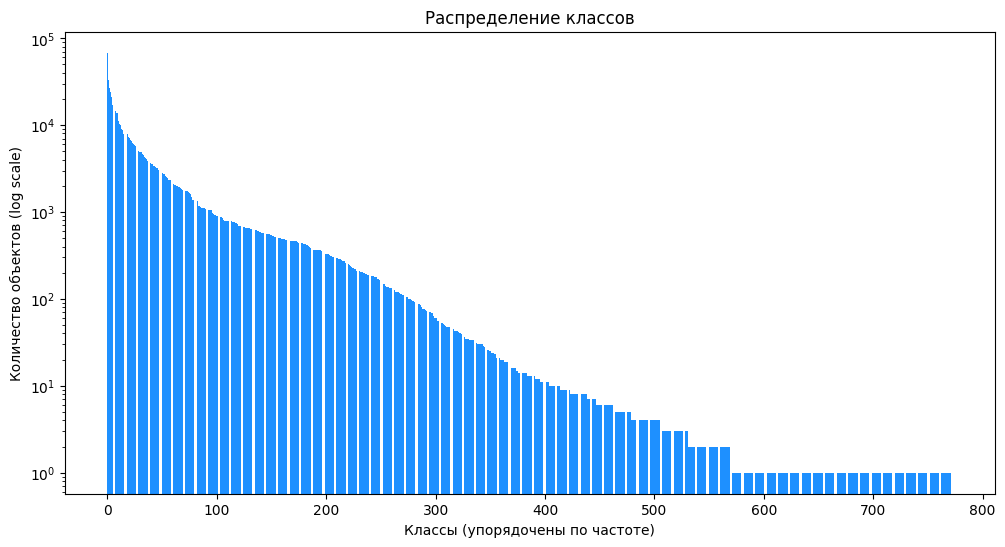

In [ ]:
class_counts = df['label'].value_counts()

# рисуем гистограмму с логарифмической шкалой
plt.figure(figsize=(12, 6))
plt.bar(range(len(class_counts)), class_counts.values, color='dodgerblue')
plt.yscale('log')  # логарифмическая шкала
plt.xlabel('Классы (упорядочены по частоте)')
plt.ylabel('Количество объектов (log scale)')
plt.title('Распределение классов')
plt.show()

In [ ]:
# проверяем колличество классов представленных однм экземпляром и находим их индексы
class_counts = df['label'].value_counts()
rare_classes_1 = class_counts[class_counts == 1].index
rare_classes_2 = class_counts[class_counts == 2].index
rare_classes_3 = class_counts[class_counts == 3].index
class_counts[class_counts == 1].sum()

203

In [ ]:
# копируем их, чтоб использовать stratify в train_test_split и eval_set при обучении
duplicates_1 = pd.concat([df[df['label'].isin(rare_classes_1)]] * 3, ignore_index=True)
df_train_cat = pd.concat([df, duplicates_1], ignore_index=True)

duplicates_2 = pd.concat([df[df['label'].isin(rare_classes_2)]] * 2, ignore_index=True)
df_train_cat = pd.concat([df_train_cat, duplicates_2], ignore_index=True)

duplicates_3 = pd.concat([df[df['label'].isin(rare_classes_3)]], ignore_index=True)
df_train_cat = pd.concat([df_train_cat, duplicates_3], ignore_index=True)

print(df_train_cat['label'].value_counts())

label
35     67967
370    32960
27     26945
105    24203
391    21005
       ...  
452        4
526        4
525        4
652        4
456        4
Name: count, Length: 773, dtype: int64


In [ ]:
# сохраняем датасет
#df_train_cat.to_parquet('df_train_cat.parquet', index=False)

### Анализ количества токенов в 'new_source_name'

In [ ]:
def find_max_length(df: pd.Dataframe) -> list:
    """
    Находит максимальную длину последовательности.
    """
    tokenized_texts = df['source_name_model']
    return [len(tokenizer.tokenize(text)) for text in tqdm(tokenized_texts)]


# определяем максимальную длину токенов
lst_length = find_max_length(labeled_train)
max_length = max(lst_length)  # максимальная длина
mean_length = np.mean(lst_length)  # средняя длина
percentile_95 = np.percentile(lst_length, 95)  # 95-й перцентиль

print(max_length)
print(mean_length)
print(percentile_95)

  0%|          | 0/631024 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3239 > 2048). Running this sequence through the model will result in indexing errors


3239
27.482233639291056
55.0


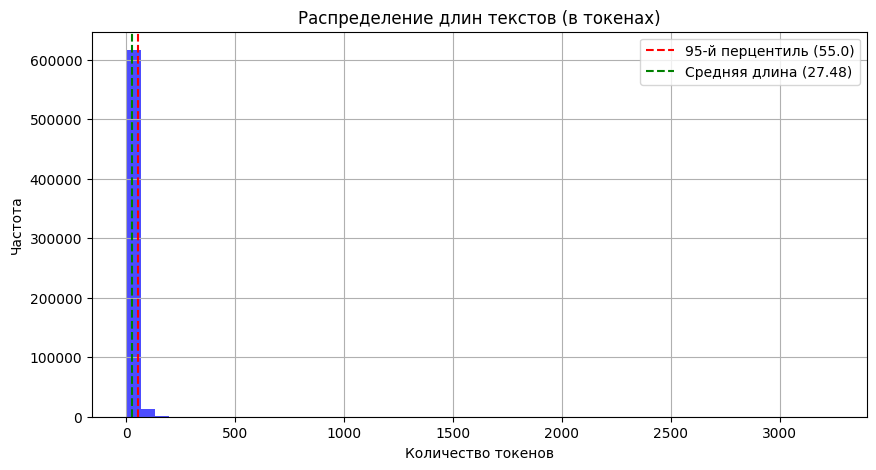

In [ ]:
# визуализация распределения длин
plt.figure(figsize=(10, 5))
pd.Series(lst_length).hist(bins=50, alpha=0.7, color='blue')
plt.axvline(percentile_95, color='red', linestyle='dashed', label=f"95-й перцентиль ({percentile_95})")
plt.axvline(mean_length, color='green', linestyle='dashed', label=f"Средняя длина ({mean_length:.2f})")
plt.title('Распределение длин текстов (в токенах)')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.legend()
plt.show()

### Выводы

**Выводы:**
1. Удалены дубликаты, их около 85к.
2. Были распарсены атрибуты в столбцы датасета.
3. Столбцы 'source_name' и 'модель' объеденены в один новый столбец 'new_source_name' и удалены.
4. Проанализирован дисбаланс классов, он большой, нужно думать что с этим делать.
5. Датасет дополнен дубликатами, чтобы использовать stratify в train_test_split и eval_set при обучении.
6. Проанализировано количество токенов в столбце 'new_source_name', берем max_lenght равным 55, так как 95 процентов наблюдений находятся в этом значений.
7. Удалены столбцы с большим количеством пропусков и другие неинфоромативные. 

## unlabeled_train

In [ ]:
# парсим атрибуты из json в текст(применяем ко всему датасету)
unlabeled_train['attributes'] = unlabeled_train['attributes'].apply(
    attributes_to_text)
unlabeled_train.head()

,hash_id,source_name,attributes
0,00003f6d7156ab7dd81559d2e89e654b,Комплект фиксации KICT CU-332,Поставщик: KICT. Цвет: серебристый; черный. Ма...
1,00004c8bf2441cf19f14d6a6aea1232d,Посудомоечная машина Vestel DF45E51W белый,Штрихкод: 4660013909774. Поставщик: Vestel. Мо...
2,0000586116fc227ad1874d6e940d1061,Уплотнитель для двери холодильника. Подходит д...,Поставщик: Нет бренда. Возможность самовывоза:...
3,000062402dc255a480a4b8d10e02d0fb,"Кронштейн для телевизора 32""""-55"""" дюймов KALO...",Длина/площадь: 32. Поставщик: KALOC. Возможнос...
4,00007882571db37ded5be37206c59a60,Unimania Держатель для телефона автомобильный ...,Поставщик: Uniluxe. Возможность самовывоза: Да...


In [ ]:
# простая очистка текста
unlabeled_train['attributes'] = unlabeled_train['attributes'].apply(
    cleaned_text)
unlabeled_train['source_name'] = unlabeled_train['source_name'].apply(
    cleaned_text)

In [ ]:
# извлекаем назначение из атрибутов unlabeled_train, создаем новые фичи
def extract_info(attr_str):
    """
    Извлекает данные из атрибутов.
    """
    # преобразуем attr_str в строку, если это не строка
    attr_str = str(attr_str) if attr_str is not None else ''

    # извлекаем назначение
    appointment_match = re.search(r'назначение:\s*([^\.]+)', attr_str)
    appointment = appointment_match.group(
        1).strip() if appointment_match else None

    # удаляем обработанные атрибуты из строки
    cleaned_attrs = re.sub(r'назначение:\s*[^\.]+\.?', '', attr_str)

    return appointment

In [ ]:
# применяем к DataFrame
unlabeled_train['назначение'] = unlabeled_train['attributes'].progress_apply(
    lambda x: pd.Series(extract_info(x)))

# удаляем старый столбец
unlabeled_train.drop(columns=['attributes'], inplace=True)
unlabeled_train.reset_index(drop=True, inplace=True)
unlabeled_train.head()

Tokenizing rows:   0%|          | 0/784742 [00:00<?, ?it/s]

,hash_id,source_name,назначение
0,00003f6d7156ab7dd81559d2e89e654b,комплект фиксации kict cu-332,для видеокарт
1,00004c8bf2441cf19f14d6a6aea1232d,посудомоечная машина vestel df45e51w белый,NaN
2,0000586116fc227ad1874d6e940d1061,уплотнитель для двери холодильника. подходит д...,NaN
3,000062402dc255a480a4b8d10e02d0fb,кронштейн для телевизора 32-55 дюймов kaloc x4...,NaN
4,00007882571db37ded5be37206c59a60,unimania держатель для телефона автомобильный ...,NaN


In [ ]:
unlabeled_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784742 entries, 0 to 784741
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   hash_id      784742 non-null  object
 1   source_name  784742 non-null  object
 2   назначение   69446 non-null   object
dtypes: object(3)
memory usage: 18.0+ MB


In [ ]:
# объединяем source_name и назначение в новый столбец name и удаляем их
unlabeled_train['name'] = unlabeled_train.apply(
    lambda row:
    f"{row['source_name']}{'' if pd.isna(row['назначение']) else '.'} {'' if pd.isna(row['назначение']) else row['назначение']}"
    .strip(),
    axis=1)
unlabeled_train.drop(['source_name', 'назначение', 'hash_id'],
                     axis=1,
                     inplace=True)

In [ ]:
unlabeled_train.head()

,name
0,комплект фиксации kict cu-332. для видеокарт
1,посудомоечная машина vestel df45e51w белый
2,уплотнитель для двери холодильника. подходит д...
3,кронштейн для телевизора 32-55 дюймов kaloc x4...
4,unimania держатель для телефона автомобильный ...


In [ ]:
# сохраняем датасет
unlabeled_train.to_parquet('unlabeled_train_name.parquet', index=False)

In [ ]:
def find_max_length(df: pd.Dataframe) -> list:
    """
    Находит максимальную длину последовательности.
    """
    tokenized_texts = df['name']
    return [len(tokenizer.tokenize(text)) for text in tqdm(tokenized_texts)]


# определяем максимальную длину токенов
lst_length = find_max_length(unlabeled_train)
max_length = max(lst_length)  # максимальная длина
mean_length = np.mean(lst_length)  # средняя длина
percentile_95 = np.percentile(lst_length, 95)  # 95-й перцентиль

print(max_length)
print(mean_length)
print(percentile_95)

  0%|          | 0/784742 [00:00<?, ?it/s]

90
15.8350719089841
27.0


**Вывод:**
В столбце датасета source_name были добавлены значения из атрибутов 'назначение', там где они присутствуют, таких значений 69444. Также была рассчитана max_length_unlabeled = 27 (95 перцентиль).

## full dataset

Разметка датасета **unlabeled_train_name** произведена в ноутбуке **"faiss"**

In [ ]:
unlabeled_train_cat_id.head()  # размеченный датасет unlabeled_train_name

,labels
0,"[1409, 2437, 1293, 13128, 30993]"
1,"[1376, 1401, 2421, 10499, 469]"
2,"[12294, 2617, 31422, 31316, 1027]"
3,"[1304, 1238, 1630, 13018, 10122]"
4,"[12580, 12610, 1268, 11610, 14052]"


In [ ]:
# добавляем разметку в unlabeled_train
unlabeled_train['cat_id'] = [i[0] for i in unlabeled_train_cat_id['labels']]
unlabeled_train.head()

,hash_id,source_name,attributes,cat_id
0,00003f6d7156ab7dd81559d2e89e654b,Комплект фиксации KICT CU-332,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",1409
1,00004c8bf2441cf19f14d6a6aea1232d,Посудомоечная машина Vestel DF45E51W белый,"[{""""attribute_id"""":6,""""attribute_name"""":""""Штри...",1376
2,0000586116fc227ad1874d6e940d1061,Уплотнитель для двери холодильника. Подходит д...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",12294
3,000062402dc255a480a4b8d10e02d0fb,"Кронштейн для телевизора 32""""-55"""" дюймов KALO...","[{""""attribute_id"""":5,""""attribute_name"""":""""Длин...",1304
4,00007882571db37ded5be37206c59a60,Unimania Держатель для телефона автомобильный ...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",12580


In [ ]:
# конкатенируем исходный размеченный датасет с датасетом который разметили сами(unlabeled_train)
full_df = pd.concat([labeled_train, unlabeled_train], ignore_index=True)
full_df.head()

,hash_id,source_name,attributes,cat_id
0,00002c14676b6a5c02d01fd82a92bd50,"Бойник барабана для стиральной машины Candy, V...","[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",10501
1,00002d434ee4516d75b9e99cb4b6b4fb,Приемное устройство М1 TDM Уютный дом в монтаж...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",140
2,000055da1f1a715b7a8c955e4002ade2,Духовой шкаф электрический Darina 1U5 BDE 112 ...,"[{""""attribute_id"""":6,""""attribute_name"""":""""Штри...",1397
3,000065493de83bdbacf9093b9e139cbb,Коврик для мыши 40*70 см Genshin Impact Desk M...,"[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",3645
4,00006bee8d0f6056ac09833a2cee2b8c,"Ripo Кабель для интернет-соединения, серый","[{""""attribute_id"""":8,""""attribute_name"""":""""Пост...",10421


Далее проводятся аналогичные исследования и преобразования что и в части - **2.2 labeled_train¶**

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501294 entries, 0 to 1501293
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   hash_id      1501294 non-null  object
 1   source_name  1501294 non-null  object
 2   attributes   1501294 non-null  object
 3   cat_id       1501294 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 45.8+ MB


In [ ]:
full_df['cat_id'].nunique()

1353

In [ ]:
# проверяем дубликаты
duplicates = full_df[full_df['source_name'].duplicated()]

In [ ]:
# удаляем дубликаты
full_df.drop_duplicates(subset='source_name', inplace=True)
full_df.drop('hash_id', axis=1, inplace=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1340387 entries, 0 to 1501293
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   source_name  1340387 non-null  object
 1   attributes   1340387 non-null  object
 2   cat_id       1340387 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 40.9+ MB


In [ ]:
# преобразуем атрибуты из jason в текст
full_df['attributes'] = labeled_train['attributes'].apply(attributes_to_text)
full_df.head()

,source_name,attributes,cat_id
0,"Бойник барабана для стиральной машины Candy, V...",Поставщик: Нет бренда. Возможность самовывоза:...,10501
1,Приемное устройство М1 TDM Уютный дом в монтаж...,Поставщик: TDM Electric. Возможность самовывоз...,140
2,Духовой шкаф электрический Darina 1U5 BDE 112 ...,Штрихкод: 4607152046304. Поставщик: DARINA. Во...,1397
3,Коврик для мыши 40*70 см Genshin Impact Desk M...,Поставщик: Genshin Impact. Возможность самовыв...,3645
4,"Ripo Кабель для интернет-соединения, серый",Поставщик: Ripo. Возможность самовывоза: Да. В...,10421


In [ ]:
# чистим датасет
full_df['attributes'] = full_df['attributes'].apply(cleaned_text)
full_df['source_name'] = full_df['source_name'].apply(cleaned_text)
full_df.head()

,source_name,attributes,cat_id
0,"бойник барабана для стиральной машины candy, v...",поставщик: нет бренда. возможность самовывоза:...,10501
1,приемное устройство м1 tdm уютный дом в монтаж...,поставщик: tdm electric. возможность самовывоз...,140
2,духовой шкаф электрический darina 1u5 bde 112 ...,штрихкод: 4607152046304. поставщик: darina. во...,1397
3,коврик для мыши 40*70 см genshin impact desk m...,поставщик: genshin impact. возможность самовыв...,3645
4,"ripo кабель для интернет-соединения, серый",поставщик: ripo. возможность самовывоза: да. в...,10421


In [ ]:
# применяем к DataFrame
full_df[[
    'поставщик', 'страна', 'материал', 'модель', 'самовывоз', 'длина',
    'ширина', 'высота', 'возможность доставки', 'гарантия', 'вес', 'длина_уп',
    'ширина_уп', 'высота_уп'
]] = full_df['attributes'].progress_apply(lambda x: pd.Series(extract_info(x)))

# удаляем старый столбец
full_df.drop(columns=['attributes'], inplace=True)
full_df.reset_index(drop=True, inplace=True)
full_df.head()

Tokenizing rows:   0%|          | 0/1340387 [00:00<?, ?it/s]

,source_name,cat_id,поставщик,страна,материал,модель,самовывоз,длина,ширина,высота,возможность доставки,гарантия,вес,длина_уп,ширина_уп,высота_уп
0,"бойник барабана для стиральной машины candy, v...",10501,None,турция,пластик,кх-0012297,1.0,18.0,5.0,5.0,0.0,0.0,100.0,NaN,NaN,NaN
1,приемное устройство м1 tdm уютный дом в монтаж...,140,tdm electric,китай,None,sq1508-0213,1.0,5.0,5.0,10.0,0.0,1.0,150.0,NaN,NaN,NaN
2,духовой шкаф электрический darina 1u5 bde 112 ...,1397,darina,None,None,электрический 1u5 bde 112 708 x5 серебристый 0...,1.0,NaN,NaN,NaN,1.0,0.0,35900.0,NaN,NaN,NaN
3,коврик для мыши 40*70 см genshin impact desk m...,3645,genshin impact,китай,None,desk matzephyr of the violet garden,1.0,70.0,40.0,1.0,0.0,0.0,600.0,NaN,NaN,NaN
4,"ripo кабель для интернет-соединения, серый",10421,ripo,None,None,003-300007,1.0,17.0,14.0,3.0,0.0,1.0,61.0,NaN,NaN,NaN


In [ ]:
# рассчитываем пропуски
for j in full_df.columns:
    a = round(full_df[j].isna().sum() / full_df.shape[0] * 100, 3)
    print(f'Доля пропусков в {j}: {a}%')

Доля пропусков в source_name: 0.0%
Доля пропусков в cat_id: 0.0%
Доля пропусков в поставщик: 65.032%
Доля пропусков в страна: 81.935%
Доля пропусков в материал: 96.471%
Доля пропусков в модель: 79.712%
Доля пропусков в самовывоз: 0.0%
Доля пропусков в длина: 85.293%
Доля пропусков в ширина: 85.293%
Доля пропусков в высота: 85.293%
Доля пропусков в возможность доставки: 0.0%
Доля пропусков в гарантия: 0.0%
Доля пропусков в вес: 79.703%
Доля пропусков в длина_уп: 99.979%
Доля пропусков в ширина_уп: 99.979%
Доля пропусков в высота_уп: 99.979%


In [ ]:
# объединяем source_name и модель в новый столбец source_name_model и удаляем их
full_df['source_name_model'] = full_df.apply(
    lambda row:
    f"{row['source_name']}{'.' if row['модель'] is not None else ''} {row['модель'] or ''}"
    .strip(),
    axis=1)
full_df.drop(['source_name', 'модель'], axis=1, inplace=True)

In [ ]:
# удаляем столбцы где много пропусков
full_df.drop([
    'поставщик', 'страна', 'длина', 'ширина', 'высота', 'вес', 'материал',
    'длина_уп', 'ширина_уп', 'высота_уп'
],
             axis=1,
             inplace=True)

In [ ]:
# преобразовываем данные
for i in full_df.columns:
    if full_df[i].dtype == 'object':
        full_df[i] = full_df[i].astype('category')
    if i in ('самовывоз', 'возможность доставки', 'гарантия'):
        full_df[i] = full_df[i].astype('int8')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340387 entries, 0 to 1340386
Data columns (total 5 columns):
 #   Column                Non-Null Count    Dtype   
---  ------                --------------    -----   
 0   cat_id                1340387 non-null  int64   
 1   самовывоз             1340387 non-null  int8    
 2   возможность доставки  1340387 non-null  int8    
 3   гарантия              1340387 non-null  int8    
 4   source_name_model     1340387 non-null  category
dtypes: category(1), int64(1), int8(3)
memory usage: 61.6 MB


In [ ]:
# кодируем cat_id с помощью LabelEncoder()
label_encoder = LabelEncoder()
full_df['label'] = label_encoder.fit_transform(full_df['cat_id'])
num_classes = len(label_encoder.classes_)
full_df.head()

,cat_id,самовывоз,возможность доставки,гарантия,source_name_model,label
0,10501,1,0,0,"бойник барабана для стиральной машины candy, v...",662
1,140,1,0,1,приемное устройство м1 tdm уютный дом в монтаж...,14
2,1397,1,1,0,духовой шкаф электрический darina 1u5 bde 112 ...,181
3,3645,1,0,0,коврик для мыши 40*70 см genshin impact desk m...,542
4,10421,1,0,1,"ripo кабель для интернет-соединения, серый. 00...",640


In [ ]:
# сохраняем encoder
with open('encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [ ]:
# сохраняем датасет
full_df.to_parquet('full_df.parquet', index=False)

### Анализ дисбаланса классов

In [ ]:
# проверяем колличество классов представленных однм экземпляром и находим их индексы
class_counts = full_df['label'].value_counts()
rare_classes_1 = class_counts[class_counts == 1].index
rare_classes_2 = class_counts[class_counts == 2].index
rare_classes_3 = class_counts[class_counts == 3].index
class_counts[class_counts == 1].sum()

35

In [ ]:
# копируем их, чтоб использовать stratify в train_test_split и eval_set при обучении
duplicates_1 = pd.concat([full_df[full_df['label'].isin(rare_classes_1)]] * 3,
                         ignore_index=True)
df_train_cat = pd.concat([full_df, duplicates_1], ignore_index=True)

duplicates_2 = pd.concat([full_df[full_df['label'].isin(rare_classes_2)]] * 2,
                         ignore_index=True)
df_train_cat = pd.concat([df_train_cat, duplicates_2], ignore_index=True)

duplicates_3 = pd.concat([full_df[full_df['label'].isin(rare_classes_3)]],
                         ignore_index=True)
df_train_cat = pd.concat([df_train_cat, duplicates_3], ignore_index=True)

print(df_train_cat['label'].value_counts())

label
67     68008
886    66090
166    39967
640    33819
58     26945
       ...  
448        4
316        4
413        4
45         4
423        4
Name: count, Length: 1352, dtype: int64


In [ ]:
# сохраняем датасет
df_train_cat.to_parquet('df_train_cat.parquet', index=False)

### Анализ количества токенов в 'new_source_name'

In [ ]:
def find_max_length(df: pd.DataFrame) -> list:
    """
    Находит максимальную длину последовательности.
    """
    tokenized_texts = df['source_name_model']
    return [len(tokenizer.tokenize(text)) for text in tqdm(tokenized_texts)]


# определяем максимальную длину токенов
lst_length = find_max_length(df_train_cat)
max_length = max(lst_length)  # максимальная длина
mean_length = np.mean(lst_length)  # средняя длина
percentile_95 = np.percentile(lst_length, 95)  # 95-й перцентиль

print(max_length)
print(mean_length)
print(percentile_95)

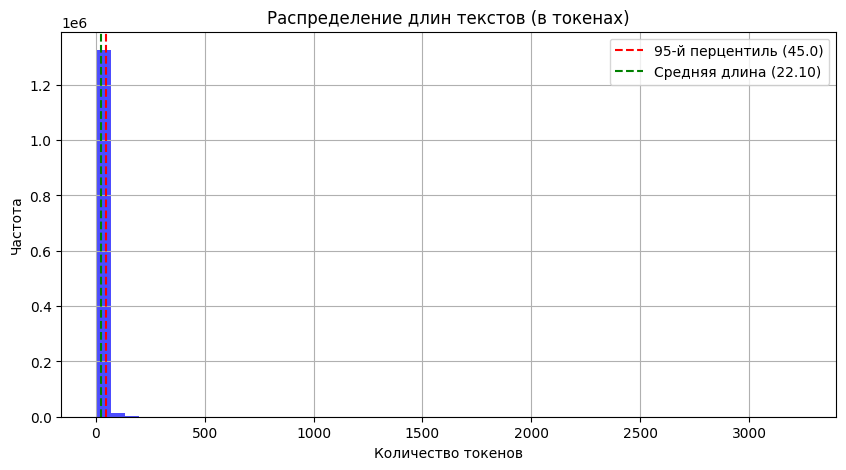

In [ ]:
# визуализация распределения длин
plt.figure(figsize=(10, 5))
pd.Series(lst_length).hist(bins=50, alpha=0.7, color='blue')
plt.axvline(percentile_95,
            color='red',
            linestyle='dashed',
            label=f"95-й перцентиль ({percentile_95})")
plt.axvline(mean_length,
            color='green',
            linestyle='dashed',
            label=f"Средняя длина ({mean_length:.2f})")
plt.title('Распределение длин текстов (в токенах)')
plt.xlabel('Количество токенов')
plt.ylabel('Частота')
plt.legend()
plt.show()

### Выводы

**Выводы:**
1. Был размечен датасет unlabeled_train с помощью поиска похожих cat_id в category_tree по косинусному расстоянию, количество размеченных классов было увеличено до 1353 экземпляров.
2. Были произведены все вышеупомянутые преобразования, а также вычисленно max_lenght = 45.